# Import

In [1]:
import pandas as pd
import pickle
import pywt, math
import statsmodels.api as sm
from tensorflow.keras.models import save_model
import os
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.linear_model import ElasticNet
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import BayesianOptimization
import random
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import regularizers
from pandas.plotting import lag_plot
from datetime import datetime
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import r2_score
import time
from tensorflow.keras.utils import plot_model
from keras.regularizers import l1, l2
from tensorflow.keras.regularizers import l1_l2
from datetime import timedelta
from scipy.spatial import KDTree
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.models import load_model
from IPython.display import Image
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch
from sklearn.model_selection import TimeSeriesSplit
import scipy.io
from sklearn.model_selection import TimeSeriesSplit

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1724575977.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [26]:
path = r"USD_CHF_RV_89_93.csv.zip"
df = pd.read_csv(f'{path}', compression = 'zip') 
rv = df.rvfx.values
r = np.flip(rv - np.mean(rv)) # Flip the data for convenience
test_size = 520
r_test = np.flip(r[:test_size]) # This corresponds to the last 520 observation (The most recent ones)
r = np.append(r, 0)
ts = np.arange(0, len(r))

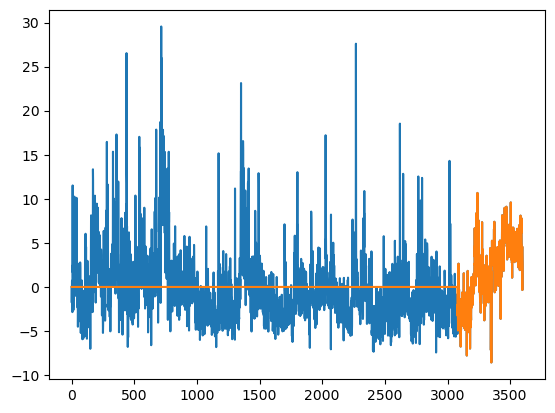

In [27]:
plt.plot(np.flip(r))
plt.plot(np.concatenate((np.zeros((len(r)-test_size),),r_test)))

In [28]:
def comparison_test_set(original_series,horizon):

    original_series = original_series[:-1]
    compare = np.zeros((len(original_series) - horizon + 1,))

    for i in range(len(compare)):

        compare[i] = np.mean(original_series[i:i+horizon])

    return np.flip(compare)[-test_size+horizon:]

# DWT

In [1]:
c = 1/2
dec_lo, dec_hi, rec_lo, rec_hi = [c, c], [-c, c], [1, 1], [1, -1]
filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
BandiWavelet = pywt.Wavelet(name="Bandi", filter_bank=filter_bank)

NameError: name 'pywt' is not defined

In [ ]:
(A1, D1) = pywt.dwt(r, BandiWavelet)
(A2, D2) = pywt.dwt(A1, BandiWavelet)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(r), 2**1)
ts2 = np.arange(0, len(r), 2**2)

In [2]:
def bring_to_original_size(arr, j):

  # This function accepts the wavelet coefficients and depending on the scale
  # will return the wavelet coefficients that are of the same size as the
  # original realized volatility time series (3600), by filling zeros in between.

  output = np.array([])

  zeros_array = np.zeros(2**j-1)

  for i in range(len(arr)):

    output = np.append(output, arr[i])

    output = np.concatenate((output, zeros_array))

  return output

def adjust_size(A,D):

  # Since we model the scales using the other scales, for the j=3 coefficients
  # last 7 observations are 0s, for j=2 its 3 and for j=1 its 1. Hence the output
  # is the matrix of wavelet coefficients being all of the size of the coefficients
  # for j=3. Check the output.

  lengths = []

  for i in range(A.shape[1]):

      lengths.append(np.where(A[:,i] == A[:,i][A[:,i] != 0][-1])[0][0]+1)

  cutoff = np.min(lengths)

  A_output = A[:cutoff,:]
  D_output = D[:cutoff,:]

  return A_output, D_output

fA1 = bring_to_original_size(A1, 1)
fA2 = bring_to_original_size(A2, 2)
fD1 = bring_to_original_size(D1, 1)
fD2 = bring_to_original_size(D2, 2)

fA = np.column_stack((fA1,fA2))
fD = np.column_stack((fD1,fD2))
fA, fD = adjust_size(fA,fD)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(fA), 2**1)
ts2 = np.arange(0, len(fA), 2**2)

NameError: name 'A1' is not defined

In [32]:
# Assembling function
def assemble(position, yA2, yD2, yD1):

    a2 = yA2

    if position == 3:

        d2 = -yD2
        d1 = -yD1

    elif position == 2:
        d2 = -yD2
        d1 = yD1

    elif position == 1:
        d2 = yD2
        d1 = -yD1

    elif position == 0:
        d2 = yD2
        d1 = yD1

    output = a2 + d2 + d1

    return output

In [33]:
def check_1(ind_mat):
    checker = 0
    for i in range(len(ind_mat)):
        if np.sum(ind_mat[i,0] < ind_mat[i,1:]) != len(ind_mat[i,1:]):
            print(f"Check observation {i}")
            print(f"Row is {ind_mat[i,:]}")
            print('                          ')
        else:
            checker += 1
    return checker == len(ind_mat)

def check_2(ind_mat):
    checker = 0
    for i in range(len(ind_mat)):
        row = ind_mat[i,:]
        y = row[0]
        x = row[1:]
        check = 0
        for j in range(len(x)):
            if x[j] > y:
                check += 1
        if check == len(x):
            checker += 1
        else:
            print(f'Something is wrong with the order, check row {i}')
            print(f'{row}')
            print(f'           ')
    return checker == len(ind_mat)

In [34]:
def adj(M, j, struct, num_lags):

    num_lags = np.array(num_lags).astype(int)

    lags = [np.arange(struct[0],struct[0]+num_lags[0]),np.arange(struct[1],struct[1]+num_lags[1])]

    Jmax = num_lags[0]+num_lags[1]

    max_inds = [-2*(num_lags[0]+struct[0]-1)-1, -4*(num_lags[1]+struct[1]-1)-1]
    idxcount = len(M) + np.min(max_inds)

    if j == 2:
        idx = ts2[ts2 < idxcount][-1]
    elif j == 1:
        idx = ts1[ts1 < idxcount][-1]

    y_idx = np.arange(0,idx+1,2**j)

    X = np.zeros((len(y_idx),Jmax))
    X_ind = np.zeros((len(y_idx),Jmax))

    X_indices = {1:np.arange(0,num_lags[0]),2:np.arange(num_lags[0],num_lags[0]+num_lags[1])}

    for k in range(M.shape[1]):

        X_idx = np.nonzero(fA[:,k])[0]

        indices = np.zeros((len(y_idx),num_lags[k]), dtype=int)

        for i in range(len(y_idx)):

            current_y_idx = y_idx[i]

            try:

                x_idx = X_idx[X_idx > current_y_idx][lags[k]]

            except:

                print('Something is wrong')

            indices[i,:] = x_idx

        X[:,X_indices[k+1]] = M[indices,k]
        X_ind[:,X_indices[k+1]] = indices

    y = M[y_idx,j-1]
    reg_mat = np.column_stack((y,X))
    reg_mat_ind = np.column_stack((y_idx,X_ind))

    # Do the checks to see if data is in the right order/format
    # print("Check. Checking if the index of y is always smaller than the indices of any feature included, status = ",check_1(reg_mat_ind),check_2(reg_mat_ind))
#     print("                   ")
    return reg_mat

In [35]:
def generate_data(num_lags_dict, fA = fA, fD = fD):

    Reg_data_dict = {}

    lags = [0,0,0]
    num_lags = num_lags_dict[1]
    a_reg_mat, d_reg_mat = adj(fA, 1, lags, num_lags), adj(fD, 1, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[1] = reg_mat

    lags = [0,0,0]
    num_lags = num_lags_dict[2]
    a_reg_mat, d_reg_mat = adj(fA, 2, lags, num_lags), adj(fD, 2, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[2] = reg_mat

    lags = [1,0,0]
    num_lags = num_lags_dict[3]
    a_reg_mat, d_reg_mat = adj(fA, 2, lags, num_lags), adj(fD, 2, lags, num_lags)
    reg_mat = {"A":a_reg_mat, "D":d_reg_mat}
    Reg_data_dict[3] = reg_mat

    return Reg_data_dict

# NN New method

In [36]:
# Define the hyperparameter search space
class MyHyperModel(kt.HyperModel):

    def build(self, hp):

        model = Sequential()

        # pick activation function
        hp_act_func = hp.Choice('activation', values=['tanh','sigmoid','relu'])

        # Add input layer
        l2_reg = hp.Float('l2_regularization', min_value=0, max_value=0.3, step=0.01)
        l1_reg = hp.Float('l1_regularization', min_value=0, max_value=0.3, step=0.01)

        model.add(Dense(units=X_train.shape[1], activation=hp_act_func, input_dim=X_train.shape[1], kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))

        model.add(BatchNormalization())

        for i in range(hp.Int('num_layers', min_value=1, max_value=1, step=1)):

            l2_reg = hp.Float('l2_regularization_'+str(i), min_value=0, max_value=0.4, step=0.01)
            l1_reg = hp.Float('l1_regularization_'+str(i), min_value=0, max_value=0.4, step=0.01)

            hp_units = hp.Int('hidden_units_'+str(i), min_value=10, max_value=200, step=5)

            hp_act_func = hp.Choice('activation'+str(i), values=['tanh','sigmoid','relu'])

            model.add(Dense(units=hp_units, activation=hp_act_func, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))

            model.add(BatchNormalization())

        # Add output layer
        model.add(Dense(units=2, activation='linear'))

        hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.05, 0.005, 0.00005])

        hp_weight_decay = hp.Choice('weight_decay', values=[0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

        opt = tf.keras.optimizers.Adam(
                learning_rate=hp_learning_rate,
                name="Adam",weight_decay=hp_weight_decay)

        # Compile the model
        model.compile(optimizer=opt, loss='mse', metrics=["mean_absolute_error"])

        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):

        return model.fit(
            x,
            y,
            validation_data=validation_data,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256]),
            epochs = hp.Int('epochs', min_value=200, max_value=300, step=10),
            **kwargs,
        )

In [37]:
from keras.callbacks import Callback
class BestValidationLossCallback(Callback):
    def __init__(self):
        super(BestValidationLossCallback, self).__init__()
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

    def on_train_end(self, logs=None):
        print('Best validation loss: {}'.format(self.best_val_loss))

In [38]:
def tune_nn(training_X, training_y, validation_X, validation_y, scale, iter, trial):

        save_directory = f'Adaptive_tuning/trial_{trial}/Reg_{scale}/iter_{iter}'

        max_trials = 50

        tuner = BayesianOptimization(MyHyperModel(),
                objective='val_loss',
                num_initial_points=20,
                max_trials=max_trials,
                directory=save_directory,
                project_name=f'RV_forecasting',
                overwrite = True)

        callback = BestValidationLossCallback()

        tuner.search(training_X, training_y, validation_data = (validation_X, validation_y),callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3),callback],verbose = 0)
        
        best_model = tuner.get_best_models(1)[0]
        save_model(best_model, f'{save_directory}/model_{iter}.h5')

        best_hps = tuner.get_best_hyperparameters(30)
        hp_directory = f'{save_directory}/hps_{iter}.pkl'
        with open(hp_directory, 'wb') as file:
                pickle.dump(best_hps, file)
        
        return best_model, best_hps

In [39]:
trial = 1
batch_size = 44
num_lags_dict = {1:[30,30],2:[30,30],3:[30,30]}
Reg_data_dict = generate_data(num_lags_dict)
training_ratio = 0.7
validation_ratio = 0.3

In [40]:
for i in range(1,3):

    yd = np.flip(Reg_data_dict[i]['D'][:,0])
    Xd = np.flip(Reg_data_dict[i]['D'][:,1:],0)
    ya = np.flip(Reg_data_dict[i]['A'][:,0])
    Xa = np.flip(Reg_data_dict[i]['A'][:,1:],0)

    X = np.column_stack((Xa,Xd))
    y = np.column_stack((ya,yd))

    update_size = np.copy(test_size)
    iteration = 1

    while update_size > 0:

        print(f"Current update size is {update_size} and current scale is {i}")

        train_size = int(len(ya) - update_size/(2**i))
        val_size = np.floor(train_size * validation_ratio).astype(int)

        X_train, X_test = X[:train_size,:], X[train_size:,:]
        y_train, y_test = y[:train_size,:], y[train_size:,:]

        X_val, y_val = X_train[-val_size:,:], y_train[-val_size:,:]
        X_train, y_train = X_train[:-val_size,:], y_train[:-val_size,:]

        model, hp = tune_nn(X_train, y_train, X_val, y_val, i, iteration, trial)

        update_size = update_size - batch_size

        iteration = iteration + 1


Current update size is 520 and current scale is 1
Best validation loss: 26.215633392333984
Best validation loss: 7.488504409790039
Best validation loss: 694.350341796875
Best validation loss: 7.000074863433838
Best validation loss: 8.555575370788574
Best validation loss: 8.584161758422852
Best validation loss: 11.940953254699707
Best validation loss: 20.567420959472656
Best validation loss: 161.1753692626953
Best validation loss: 6.407491207122803
Best validation loss: 151.85256958007812
Best validation loss: 36.057369232177734
Best validation loss: 316.3294677734375
Best validation loss: 37.10983657836914
Best validation loss: 24.40593147277832
Best validation loss: 121.10980987548828
Best validation loss: 12.004537582397461
Best validation loss: 40.094398498535156
Best validation loss: 11.298891067504883
Best validation loss: 5.419666767120361
Best validation loss: 4.744312763214111
Best validation loss: 9.922039985656738
Best validation loss: 29.484251022338867
Best validation loss:

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 476 and current scale is 1
Best validation loss: 59.768951416015625
Best validation loss: 60.145904541015625
Best validation loss: 8.060742378234863
Best validation loss: 52.36336898803711
Best validation loss: 6.658105850219727
Best validation loss: 10.538784980773926
Best validation loss: 151.2156524658203
Best validation loss: 56.4187126159668
Best validation loss: 4.456160068511963
Best validation loss: 11.292608261108398
Best validation loss: 7.013861656188965
Best validation loss: 35.999183654785156
Best validation loss: 9.904715538024902
Best validation loss: 7.5368146896362305
Best validation loss: 7.731151103973389
Best validation loss: 4.65449857711792
Best validation loss: 43.17470169067383
Best validation loss: 13.71731185913086
Best validation loss: 9.615071296691895
Best validation loss: 8.650493621826172


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 58.3181037902832
Best validation loss: 12.372989654541016
Best validation loss: 10.086380958557129
Best validation loss: 14.116111755371094
Best validation loss: 24.910812377929688
Best validation loss: 10.01558780670166
Best validation loss: 6.214799404144287
Best validation loss: 7.910337448120117
Best validation loss: 6.359682559967041
Best validation loss: 8.877166748046875
Best validation loss: 11.694046974182129
Best validation loss: 7.544763565063477
Best validation loss: 12.187512397766113
Best validation loss: 22.115711212158203
Best validation loss: 9.430011749267578
Best validation loss: 6.76997184753418
Best validation loss: 21.433183670043945
Best validation loss: 377.4803466796875
Best validation loss: 11.941600799560547
Best validation loss: 6.619654178619385
Best validation loss: 8.260323524475098
Best validation loss: 10.100285530090332
Best validation loss: 9.998414993286133
Best validation loss: 5.739291667938232
Best validation loss: 6.33217048

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 432 and current scale is 1
Best validation loss: 20.728254318237305
Best validation loss: 74.85633850097656
Best validation loss: 101.70210266113281
Best validation loss: 456.7337646484375
Best validation loss: 40.55928421020508
Best validation loss: 28.488447189331055
Best validation loss: 30.146577835083008
Best validation loss: 11.931584358215332
Best validation loss: 85.84585571289062
Best validation loss: 7.247346878051758
Best validation loss: 6.559067249298096
Best validation loss: 172.94236755371094
Best validation loss: 84.49977111816406
Best validation loss: 17.313114166259766
Best validation loss: 5.400216102600098
Best validation loss: 5.328129768371582
Best validation loss: 5.341123580932617
Best validation loss: 41.59945297241211
Best validation loss: 17.6510066986084
Best validation loss: 228.96542358398438
Best validation loss: 24.712570190429688
Best validation loss: 283.1202087402344
Best validation loss: 4.505190372467041
Best validation loss: 

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 388 and current scale is 1
Best validation loss: 7.059826374053955
Best validation loss: 9.654658317565918
Best validation loss: 20.186447143554688
Best validation loss: 5.962066650390625
Best validation loss: 365.0809020996094
Best validation loss: 326.0533752441406
Best validation loss: 5.930963516235352
Best validation loss: 4.032998561859131
Best validation loss: 29.669483184814453
Best validation loss: 67.03236389160156
Best validation loss: 49.10906219482422
Best validation loss: 5.235555648803711
Best validation loss: 6.167550086975098
Best validation loss: 54.14267349243164
Best validation loss: 7.49114465713501
Best validation loss: 4.262202739715576
Best validation loss: 5.207612037658691
Best validation loss: 125.42350006103516
Best validation loss: 3.730506658554077
Best validation loss: 40.145851135253906
Best validation loss: 37.20122146606445
Best validation loss: 67.65036010742188
Best validation loss: 22.66020393371582
Best validation loss: 8.111

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 344 and current scale is 1
Best validation loss: 59.781681060791016
Best validation loss: 5.7372236251831055
Best validation loss: 24.179014205932617
Best validation loss: 6.048186302185059
Best validation loss: 33.746429443359375
Best validation loss: 9.373673439025879
Best validation loss: 33.728851318359375
Best validation loss: 6.262847423553467
Best validation loss: 15.91079044342041
Best validation loss: 207.8301239013672
Best validation loss: 11.858810424804688
Best validation loss: 27.70492172241211
Best validation loss: 118.0539779663086
Best validation loss: 59.1064567565918
Best validation loss: 41.52384567260742
Best validation loss: 6.010212421417236
Best validation loss: 5.501534461975098
Best validation loss: 9.52686595916748
Best validation loss: 10.779877662658691
Best validation loss: 6.0539631843566895


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.026261329650879


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 112.4146499633789


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 18.700889587402344


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 5.563816070556641


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.596787452697754
Best validation loss: 5.552953243255615
Best validation loss: 12.567464828491211
Best validation loss: 16.23235321044922
Best validation loss: 86.1971664428711
Best validation loss: 7.429376125335693
Best validation loss: 383.4725036621094
Best validation loss: 5.434082984924316
Best validation loss: 15.564651489257812
Best validation loss: 23.12022590637207
Best validation loss: 7.370031356811523
Best validation loss: 23.650693893432617
Best validation loss: 6.985517978668213
Best validation loss: 100.18760681152344
Best validation loss: 40.47578430175781
Best validation loss: 4.915872573852539
Best validation loss: 8.248851776123047
Best validation loss: 16.081375122070312
Best validation loss: 7.637243270874023
Best validation loss: 8.141846656799316
Best validation loss: 19.182592391967773
Best validation loss: 6.887850284576416
Best validation loss: 12.200560569763184
Best validation loss: 8.020523071289062
Best validation loss: 16.04129600

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 300 and current scale is 1
Best validation loss: 48.45001220703125
Best validation loss: 33.659912109375
Best validation loss: 36.419864654541016
Best validation loss: 27.538333892822266
Best validation loss: 33.5545654296875
Best validation loss: 4.004245758056641
Best validation loss: 15.015252113342285
Best validation loss: 69.0533447265625
Best validation loss: 6.50075101852417
Best validation loss: 56.767032623291016
Best validation loss: 12.387401580810547
Best validation loss: 4.515862941741943
Best validation loss: 53.79975891113281
Best validation loss: 41.09152603149414
Best validation loss: 5.6405463218688965
Best validation loss: 33.05181121826172
Best validation loss: 110.65162658691406
Best validation loss: 12.813492774963379
Best validation loss: 4.230838775634766
Best validation loss: 69.21868133544922


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 34.058284759521484


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 4.860793113708496


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 490.88330078125
Best validation loss: 33.867069244384766
Best validation loss: 9.524771690368652
Best validation loss: 38.89827346801758
Best validation loss: 3.665482997894287
Best validation loss: 8.506976127624512
Best validation loss: 20.230083465576172
Best validation loss: 4.178051948547363
Best validation loss: 13.068181037902832
Best validation loss: 4.725722789764404
Best validation loss: 4.555757522583008
Best validation loss: 33.89858627319336
Best validation loss: 4.59623384475708
Best validation loss: 13.481274604797363
Best validation loss: 27.712800979614258
Best validation loss: 9.935808181762695
Best validation loss: 7.590029716491699
Best validation loss: 5.346385955810547
Best validation loss: 3.7549991607666016
Best validation loss: 8.52707290649414
Best validation loss: 5.6341633796691895
Best validation loss: 123.36235809326172
Best validation loss: 14.698615074157715
Best validation loss: 212.85755920410156
Best validation loss: 4.6872997283

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 256 and current scale is 1
Best validation loss: 10.635926246643066
Best validation loss: 8.731941223144531
Best validation loss: 36.90852737426758
Best validation loss: 6.821737289428711
Best validation loss: 38.17930603027344
Best validation loss: 3.767703056335449
Best validation loss: 26.139909744262695
Best validation loss: 3.98770809173584
Best validation loss: 262.148193359375
Best validation loss: 330.8374938964844
Best validation loss: 28.829391479492188
Best validation loss: 8.539952278137207
Best validation loss: 182.37258911132812
Best validation loss: 7.101219654083252
Best validation loss: 4.80082368850708
Best validation loss: 50.19108581542969
Best validation loss: 5.528698921203613
Best validation loss: 3.784899950027466
Best validation loss: 7.757133960723877
Best validation loss: 10.23831558227539
Best validation loss: 5.695711612701416
Best validation loss: 32.96321487426758
Best validation loss: 12.790574073791504
Best validation loss: 3.4393

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 212 and current scale is 1
Best validation loss: 60.772430419921875
Best validation loss: 13.443711280822754
Best validation loss: 4.01194429397583
Best validation loss: 34.81926727294922
Best validation loss: 57.462520599365234
Best validation loss: 12.380878448486328
Best validation loss: 6.46158504486084
Best validation loss: 27.82227325439453
Best validation loss: 355.5929260253906
Best validation loss: 4.685730934143066
Best validation loss: 8.367560386657715
Best validation loss: 29.9637451171875
Best validation loss: 4.230854511260986
Best validation loss: 6.972154140472412
Best validation loss: 5.5438385009765625
Best validation loss: 5.334114074707031
Best validation loss: 56.49991989135742
Best validation loss: 7.343450546264648
Best validation loss: 323.174560546875
Best validation loss: 11.425667762756348


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.481141090393066
Best validation loss: 5.15752649307251
Best validation loss: 3.9426066875457764
Best validation loss: 5.671981334686279
Best validation loss: 23.86594581604004
Best validation loss: 24.477432250976562
Best validation loss: 13.74572467803955
Best validation loss: 5.259599685668945
Best validation loss: 6.557382106781006
Best validation loss: 7.548203468322754
Best validation loss: 12.74778938293457
Best validation loss: 70.43566131591797
Best validation loss: 6.706455707550049
Best validation loss: 57.47406768798828
Best validation loss: 15.414488792419434
Best validation loss: 6.21581506729126
Best validation loss: 5.435067176818848
Best validation loss: 5.304988861083984
Best validation loss: 47.450286865234375
Best validation loss: 19.943344116210938
Best validation loss: 5.981986999511719
Best validation loss: 10.014347076416016
Best validation loss: 58.226627349853516
Best validation loss: 6.88716983795166
Best validation loss: 5.837080478668

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 168 and current scale is 1
Best validation loss: 14.08150577545166
Best validation loss: 165.9253387451172
Best validation loss: 31.452857971191406
Best validation loss: 10.891544342041016
Best validation loss: 108.39527130126953
Best validation loss: 34.95186233520508
Best validation loss: 6.672662258148193
Best validation loss: 13.824625968933105
Best validation loss: 5.991273880004883
Best validation loss: 6.2739458084106445
Best validation loss: 20.569250106811523
Best validation loss: 36.66804504394531
Best validation loss: 34.347412109375
Best validation loss: 9.257668495178223
Best validation loss: 11.040523529052734
Best validation loss: 51.57088088989258
Best validation loss: 5.746181011199951
Best validation loss: 3.8779115676879883
Best validation loss: 8.959327697753906
Best validation loss: 7.078151226043701


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 39.913883209228516


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 59.273685455322266
Best validation loss: 7.756558418273926
Best validation loss: 25.129356384277344
Best validation loss: 6.056561470031738
Best validation loss: 4.7917375564575195
Best validation loss: 6.393855571746826
Best validation loss: 4.1162824630737305
Best validation loss: 4.702905654907227
Best validation loss: 4.699095726013184
Best validation loss: 4.426579475402832
Best validation loss: 4.454631805419922
Best validation loss: 4.591820240020752
Best validation loss: 3.8408093452453613
Best validation loss: 3.870002508163452
Best validation loss: 4.300112247467041
Best validation loss: 4.199068069458008
Best validation loss: 6.371579647064209
Best validation loss: 5.114983081817627
Best validation loss: 5.157169342041016
Best validation loss: 4.519367694854736
Best validation loss: 6.0628662109375
Best validation loss: 4.421937942504883
Best validation loss: 8.974000930786133
Best validation loss: 4.239832878112793
Best validation loss: 4.4749927520751

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 124 and current scale is 1
Best validation loss: 4.539597511291504
Best validation loss: 18.022113800048828
Best validation loss: 4.371769905090332
Best validation loss: 611.216552734375
Best validation loss: 26.403648376464844
Best validation loss: 32.50907516479492
Best validation loss: 23.099843978881836
Best validation loss: 26.24703025817871
Best validation loss: 4.73441219329834
Best validation loss: 5.149847507476807
Best validation loss: 6.893872261047363
Best validation loss: 92.35585021972656
Best validation loss: 3.641139507293701
Best validation loss: 31.64398765563965
Best validation loss: 58.33149719238281
Best validation loss: 5.601032733917236
Best validation loss: 76.74642944335938
Best validation loss: 508.2795715332031
Best validation loss: 23.647018432617188
Best validation loss: 15.752645492553711
Best validation loss: 8.123509407043457
Best validation loss: 4.305410385131836
Best validation loss: 25.954132080078125
Best validation loss: 4.92

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 80 and current scale is 1
Best validation loss: 54.614017486572266
Best validation loss: 7.072896480560303
Best validation loss: 6.996650218963623
Best validation loss: 27.497154235839844
Best validation loss: 16.537702560424805
Best validation loss: 10.302591323852539
Best validation loss: 12.49226188659668
Best validation loss: 9.470235824584961
Best validation loss: 26.260725021362305
Best validation loss: 41.8262939453125
Best validation loss: 4.516345024108887
Best validation loss: 407.8263244628906
Best validation loss: 19.798519134521484
Best validation loss: 8.772886276245117
Best validation loss: 35.30807113647461
Best validation loss: 8.294133186340332
Best validation loss: 72.3033676147461
Best validation loss: 6.81530237197876
Best validation loss: 38.01730728149414
Best validation loss: 91.52632141113281
Best validation loss: 6.501343727111816
Best validation loss: 4.927440643310547
Best validation loss: 6.467866897583008
Best validation loss: 243.84

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 36 and current scale is 1
Best validation loss: 3.718555212020874
Best validation loss: 105.55013275146484
Best validation loss: 7.818422317504883
Best validation loss: 5.43878173828125
Best validation loss: 56.694034576416016
Best validation loss: 9.446702003479004
Best validation loss: 90.60005187988281
Best validation loss: 406.5304870605469
Best validation loss: 8.163838386535645
Best validation loss: 11.018630981445312
Best validation loss: 29.095401763916016
Best validation loss: 8.449054718017578
Best validation loss: 8.493119239807129
Best validation loss: 5.7204999923706055
Best validation loss: 31.294597625732422
Best validation loss: 20.376991271972656
Best validation loss: 4.056022644042969
Best validation loss: 5.435699939727783
Best validation loss: 14.276342391967773
Best validation loss: 84.38435363769531
Best validation loss: 3.737121820449829
Best validation loss: 6.8370890617370605
Best validation loss: 8.699131965637207
Best validation loss: 3

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 520 and current scale is 2
Best validation loss: 3.9470767974853516
Best validation loss: 6.541773319244385
Best validation loss: 13.442215919494629
Best validation loss: 4.145435810089111
Best validation loss: 10.011942863464355
Best validation loss: 11.855125427246094
Best validation loss: 66.40187072753906
Best validation loss: 11.302328109741211
Best validation loss: 17.50299835205078
Best validation loss: 276.81109619140625
Best validation loss: 83.23196411132812
Best validation loss: 320.0314636230469
Best validation loss: 7.999077320098877
Best validation loss: 21.33162498474121
Best validation loss: 55.02892303466797
Best validation loss: 10.535563468933105
Best validation loss: 13.239309310913086
Best validation loss: 13.644142150878906
Best validation loss: 32.131431579589844
Best validation loss: 50.80072021484375
Best validation loss: 14.068812370300293
Best validation loss: 214.1724090576172
Best validation loss: 15.085626602172852
Best validation lo

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 476 and current scale is 2
Best validation loss: 20.503355026245117
Best validation loss: 26.55898666381836
Best validation loss: 3.849449872970581
Best validation loss: 200.5334930419922
Best validation loss: 8.769814491271973
Best validation loss: 2.7545888423919678
Best validation loss: 18.689002990722656
Best validation loss: 20.965469360351562
Best validation loss: 3.462923288345337
Best validation loss: 8.847163200378418
Best validation loss: 16.990245819091797
Best validation loss: 64.634765625
Best validation loss: 291.603271484375
Best validation loss: 47.48103332519531
Best validation loss: 7.62578010559082
Best validation loss: 33.346370697021484
Best validation loss: 239.64935302734375
Best validation loss: 5.232269287109375
Best validation loss: 133.0023956298828
Best validation loss: 12.59130573272705


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 368.1743469238281


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.019469261169434
Best validation loss: 14.943351745605469
Best validation loss: 159.70236206054688
Best validation loss: 15.28534984588623
Best validation loss: 12.216583251953125
Best validation loss: 6.012729644775391
Best validation loss: 99.5931167602539
Best validation loss: 60.78156280517578
Best validation loss: 54.806800842285156
Best validation loss: 28.05206871032715
Best validation loss: 115.04621887207031
Best validation loss: 39.26386260986328
Best validation loss: 3.042752504348755
Best validation loss: 66.51866149902344
Best validation loss: 86.20699310302734
Best validation loss: 46.492000579833984
Best validation loss: 69.24308013916016
Best validation loss: 2.20241379737854
Best validation loss: 2.468636989593506
Best validation loss: 361.6624755859375
Best validation loss: 2.7553508281707764
Best validation loss: 5.656314373016357
Best validation loss: 8.898747444152832
Best validation loss: 16.023591995239258
Best validation loss: 19.603471755

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 432 and current scale is 2
Best validation loss: 2.3203155994415283
Best validation loss: 10.33737850189209
Best validation loss: 27.16529083251953
Best validation loss: 18.98217010498047
Best validation loss: 33.19606018066406
Best validation loss: 18.373571395874023
Best validation loss: 3.085097551345825
Best validation loss: 18.452360153198242
Best validation loss: 94.52166748046875
Best validation loss: 4.617552757263184
Best validation loss: 91.16645812988281
Best validation loss: 14.519444465637207
Best validation loss: 29.689525604248047
Best validation loss: 53.063663482666016
Best validation loss: 66.56257629394531
Best validation loss: 56.29930877685547
Best validation loss: 5.3322882652282715
Best validation loss: 8.39957046508789
Best validation loss: 7.9972429275512695
Best validation loss: 58.73687744140625
Best validation loss: 1.891218662261963
Best validation loss: 2.193295955657959
Best validation loss: 74.63548278808594
Best validation loss: 6

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 388 and current scale is 2
Best validation loss: 187.2111053466797
Best validation loss: 3.2546122074127197
Best validation loss: 5.61895227432251
Best validation loss: 3.0658323764801025
Best validation loss: 57.5830078125
Best validation loss: 21.973588943481445
Best validation loss: 7.0766472816467285
Best validation loss: 8.745774269104004
Best validation loss: 12.109026908874512
Best validation loss: 27.540206909179688
Best validation loss: 2.0836427211761475
Best validation loss: 212.31350708007812
Best validation loss: 136.8820037841797
Best validation loss: 5.652509689331055
Best validation loss: 6.957424640655518
Best validation loss: 297.4649658203125
Best validation loss: 116.36250305175781
Best validation loss: 6.711644649505615
Best validation loss: 96.57768249511719
Best validation loss: 56.488197326660156


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 105.24567413330078


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.813082218170166


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.351393461227417


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 16.292078018188477


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 60.6002082824707


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 89.34989166259766


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 70.24922943115234


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 65.10431671142578


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.42026424407959
Best validation loss: 8.074385643005371
Best validation loss: 2.531851291656494
Best validation loss: 3.46720290184021
Best validation loss: 8.617578506469727
Best validation loss: 4.730082988739014
Best validation loss: 16.138572692871094
Best validation loss: 21.897968292236328
Best validation loss: 3.448195457458496
Best validation loss: 2.1627304553985596
Best validation loss: 3.64377760887146
Best validation loss: 2.312406539916992
Best validation loss: 3.02980375289917
Best validation loss: 4.755683898925781
Best validation loss: 28.960508346557617
Best validation loss: 15.76616096496582
Best validation loss: 17.024913787841797
Best validation loss: 2.4014008045196533
Best validation loss: 4.528295993804932
Best validation loss: 3.8960816860198975
Best validation loss: 33.82252502441406
Best validation loss: 6.748121738433838
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 344 and current scale is 2
Best validation loss: 10.194662094116211
Best validation loss: 4.170201778411865
Best validation loss: 2.7140085697174072
Best validation loss: 4.105415344238281
Best validation loss: 10.964288711547852
Best validation loss: 7.139249324798584
Best validation loss: 111.37470245361328
Best validation loss: 22.50381088256836
Best validation loss: 7.839810371398926
Best validation loss: 245.9231719970703
Best validation loss: 3.5263869762420654
Best validation loss: 192.74742126464844
Best validation loss: 141.75186157226562
Best validation loss: 3.8620309829711914
Best validation loss: 88.88135528564453
Best validation loss: 302.99029541015625
Best validation loss: 22.929067611694336
Best validation loss: 123.8226318359375
Best validation loss: 3.839721918106079
Best validation loss: 40.68514633178711
Best validation loss: 2.252382278442383
Best validation loss: 12.533438682556152
Best validation loss: 2.4767584800720215
Best validation lo

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 300 and current scale is 2
Best validation loss: 3.373077154159546
Best validation loss: 10.688641548156738
Best validation loss: 56.53065872192383
Best validation loss: 17.195846557617188
Best validation loss: 3.937319755554199
Best validation loss: 239.40142822265625
Best validation loss: 117.45851135253906
Best validation loss: 39.179752349853516
Best validation loss: 4.440466403961182
Best validation loss: 38.28338623046875
Best validation loss: 9.028478622436523
Best validation loss: 47.51078414916992
Best validation loss: 13.375699043273926
Best validation loss: 32.24354934692383
Best validation loss: 98.55258178710938
Best validation loss: 41.03504180908203
Best validation loss: 2.1433608531951904
Best validation loss: 15.787050247192383
Best validation loss: 10.640448570251465
Best validation loss: 47.39796447753906


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 22.709569931030273


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.408928871154785


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 42.86166763305664


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 19.63965606689453


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 93.87175750732422


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 64.97342681884766


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 22.67171859741211


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.132817268371582


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 5.732089042663574


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 12.733511924743652


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 56.33077621459961


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.1258621215820312


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.464756965637207


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 367.1434631347656
Best validation loss: 6.055117130279541
Best validation loss: 54.12212371826172
Best validation loss: 4.351183891296387
Best validation loss: 24.303573608398438
Best validation loss: 39.045806884765625
Best validation loss: 5.252969741821289
Best validation loss: 2.4322853088378906
Best validation loss: 431.0563659667969
Best validation loss: 4.080048084259033
Best validation loss: 21.46379280090332
Best validation loss: 9.081457138061523
Best validation loss: 8.688343048095703
Best validation loss: 7.083709239959717
Best validation loss: 1.8885424137115479
Best validation loss: 2.3634755611419678
Best validation loss: 2.015129327774048
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 256 and current scale is 2
Best validation loss: 37.50123596191406
Best validation loss: 282.71600341796875
Best validation loss: 1.8398991823196411
Best validation loss: 338.6131286621094
Best validation loss: 27.36970329284668
Best validation loss: 39.75065612792969
Best validation loss: 39.78425598144531
Best validation loss: 8.940319061279297
Best validation loss: 275.279052734375
Best validation loss: 14.590847969055176
Best validation loss: 1.7975245714187622
Best validation loss: 139.83323669433594
Best validation loss: 12.947532653808594
Best validation loss: 2.39125919342041
Best validation loss: 40.191349029541016
Best validation loss: 59.17460632324219
Best validation loss: 28.72062873840332
Best validation loss: 61.56786346435547
Best validation loss: 15.622072219848633
Best validation loss: 86.18260955810547


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 12.808954238891602


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.78719425201416


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 696.585693359375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 207.74415588378906


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.822296142578125


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.585350036621094


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.672403335571289
Best validation loss: 2.009284019470215
Best validation loss: 22.356590270996094
Best validation loss: 1.5938266515731812
Best validation loss: 1.893011450767517
Best validation loss: 1.987768530845642
Best validation loss: 39.383426666259766
Best validation loss: 2.6952648162841797
Best validation loss: 2.4342751502990723
Best validation loss: 6.843359470367432
Best validation loss: 45.87625503540039
Best validation loss: 18.00679588317871
Best validation loss: 58.77445983886719
Best validation loss: 53.724571228027344
Best validation loss: 223.64610290527344
Best validation loss: 46.741676330566406
Best validation loss: 2.2504055500030518
Best validation loss: 44.56411361694336
Best validation loss: 51.641334533691406
Best validation loss: 12.53477668762207
Best validation loss: 2.362868547439575
Best validation loss: 3.6352615356445312
Best validation loss: 2.8795149326324463
Best validation loss: 64.41919708251953
INFO:tensorflow:Oracle trigg

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 212 and current scale is 2
Best validation loss: 21.94096565246582
Best validation loss: 15.117612838745117
Best validation loss: 363.87213134765625
Best validation loss: 195.17918395996094
Best validation loss: 35.091392517089844
Best validation loss: 1.8518457412719727
Best validation loss: 236.20985412597656
Best validation loss: 3.811331272125244
Best validation loss: 6.51889705657959
Best validation loss: 9.587814331054688
Best validation loss: 6.188628673553467
Best validation loss: 2.589101791381836
Best validation loss: 32.241912841796875
Best validation loss: 164.1857452392578
Best validation loss: 144.54940795898438
Best validation loss: 15.838915824890137
Best validation loss: 9.609476089477539
Best validation loss: 8.019514083862305
Best validation loss: 353.1455993652344
Best validation loss: 20.91387176513672


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 73.31256103515625


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.709909677505493
Best validation loss: 3.8155951499938965
Best validation loss: 6.1635518074035645
Best validation loss: 38.36086654663086
Best validation loss: 29.898462295532227
Best validation loss: 48.06480407714844
Best validation loss: 67.47191619873047
Best validation loss: 53.08298110961914
Best validation loss: 16.94902229309082
Best validation loss: 36.60145950317383
Best validation loss: 12.308053970336914
Best validation loss: 71.78761291503906
Best validation loss: 28.401845932006836
Best validation loss: 25.83782958984375
Best validation loss: 6.456801891326904
Best validation loss: 1.8105976581573486
Best validation loss: 2.1483826637268066
Best validation loss: 57.25467300415039
Best validation loss: 1.5732078552246094
Best validation loss: 10.994349479675293
Best validation loss: 5.0725884437561035
Best validation loss: 2.5078344345092773
Best validation loss: 24.354215621948242
Best validation loss: 14.241450309753418
Best validation loss: 4.497

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 168 and current scale is 2
Best validation loss: 32.523521423339844
Best validation loss: 59.990726470947266
Best validation loss: 52.49283981323242
Best validation loss: 42.4791145324707
Best validation loss: 235.1071014404297
Best validation loss: 145.55450439453125
Best validation loss: 20.442520141601562
Best validation loss: 5.298738479614258
Best validation loss: 60.1182861328125
Best validation loss: 66.19424438476562
Best validation loss: 4.3984375
Best validation loss: 6.199099063873291
Best validation loss: 2.3857955932617188
Best validation loss: 4.747269630432129
Best validation loss: 403.38800048828125
Best validation loss: 67.20816802978516
Best validation loss: 46.21481704711914
Best validation loss: 14.07243824005127
Best validation loss: 2.503594398498535
Best validation loss: 210.76683044433594
Best validation loss: 1.7701584100723267
Best validation loss: 7.758950710296631
Best validation loss: 118.53872680664062
Best validation loss: 3.4808197

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 124 and current scale is 2
Best validation loss: 15.086626052856445
Best validation loss: 55.43903350830078
Best validation loss: 55.472774505615234
Best validation loss: 103.94422912597656
Best validation loss: 8.0296630859375
Best validation loss: 10.997421264648438
Best validation loss: 133.32650756835938
Best validation loss: 22.006851196289062
Best validation loss: 35.49921417236328
Best validation loss: 7.419262409210205
Best validation loss: 59.08946990966797
Best validation loss: 44.130496978759766
Best validation loss: 31.24827003479004
Best validation loss: 12.360651016235352
Best validation loss: 113.32865905761719
Best validation loss: 286.86614990234375
Best validation loss: 5.170517921447754
Best validation loss: 51.54355239868164
Best validation loss: 59.3726806640625
Best validation loss: 2.693121910095215


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 45.38990783691406


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 276.77532958984375
Best validation loss: 7.296781063079834
Best validation loss: 74.89876556396484
Best validation loss: 11.070138931274414
Best validation loss: 3.3097989559173584
Best validation loss: 4.063735008239746
Best validation loss: 8.840773582458496
Best validation loss: 28.061006546020508
Best validation loss: 4.483853340148926
Best validation loss: 2.7380669116973877
Best validation loss: 6.864614486694336
Best validation loss: 3.230658769607544
Best validation loss: 2.8867409229278564
Best validation loss: 58.50527572631836
Best validation loss: 14.723187446594238
Best validation loss: 3.111453056335449
Best validation loss: 7.760939598083496
Best validation loss: 2.6452651023864746
Best validation loss: 4.626418590545654
Best validation loss: 2.0508053302764893
Best validation loss: 3.6324453353881836
Best validation loss: 2.05639386177063
Best validation loss: 3.421457529067993
Best validation loss: 6.960980415344238
Best validation loss: 3.0434172

C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 80 and current scale is 2
Best validation loss: 6.5998311042785645
Best validation loss: 1.8296221494674683
Best validation loss: 8.63604736328125
Best validation loss: 17.536046981811523
Best validation loss: 20.599416732788086
Best validation loss: 4.5704827308654785
Best validation loss: 8.640789031982422
Best validation loss: 4.256460189819336
Best validation loss: 9.332204818725586
Best validation loss: 3.6958281993865967
Best validation loss: 9.683660507202148
Best validation loss: 11.258776664733887
Best validation loss: 5.8497443199157715
Best validation loss: 129.9980926513672
Best validation loss: 4.076789855957031
Best validation loss: 7.890169143676758
Best validation loss: 51.75832748413086
Best validation loss: 30.943063735961914
Best validation loss: 82.41778564453125
Best validation loss: 1.9416214227676392
Best validation loss: 2.634230375289917
Best validation loss: 3.2834184169769287
Best validation loss: 27.44465446472168
Best validation loss:

C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.356477737426758


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 5.851699352264404


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.133902549743652


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 32.03068542480469


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 4.019740104675293


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 144.48902893066406


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.325693130493164


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 222.90463256835938


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 73.45545959472656


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.611516952514648


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 51.77199935913086


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.974634170532227


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.8960530757904053


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.488295078277588


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 360.2320251464844


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 5.564794540405273
Best validation loss: 27.849178314208984


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 95.42417907714844
Best validation loss: 13.227327346801758


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.450777053833008


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 66.69786834716797
Best validation loss: 120.50782775878906


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 49.270023345947266
Best validation loss: 3.285712957382202
Best validation loss: 4.949695587158203
Best validation loss: 5.8109307289123535
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


Current update size is 36 and current scale is 2
Best validation loss: 2.3675377368927
Best validation loss: 24.15386962890625
Best validation loss: 34.266075134277344
Best validation loss: 427.3688049316406
Best validation loss: 2.645808458328247
Best validation loss: 188.7213134765625
Best validation loss: 10.416481971740723
Best validation loss: 11.305466651916504
Best validation loss: 16.640127182006836
Best validation loss: 2.8296151161193848
Best validation loss: 162.76925659179688
Best validation loss: 177.15277099609375
Best validation loss: 2.0679662227630615
Best validation loss: 536.4591064453125
Best validation loss: 351.9839782714844
Best validation loss: 75.28873443603516
Best validation loss: 18.546329498291016
Best validation loss: 12.465978622436523
Best validation loss: 206.0263671875
Best validation loss: 1.6467024087905884


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 113.50306701660156


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 162.1484375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 53.33970642089844


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 1.8175148963928223


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.5885274410247803


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.8769850730896


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.081461906433105


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 31.49407958984375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 7.587144374847412


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 32.25533676147461


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 611.3939208984375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 22.933609008789062


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 383.6282653808594


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.5276505947113037


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 2.1209864616394043


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.203913688659668


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 3.063985586166382


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.072051048278809
Best validation loss: 1.764414668083191
Best validation loss: 2.1667239665985107
Best validation loss: 1.910845160484314
Best validation loss: 1.7514383792877197
Best validation loss: 2.552175998687744
Best validation loss: 18.096240997314453
Best validation loss: 2.36020565032959
Best validation loss: 2.2519218921661377
Best validation loss: 6.287112236022949
Best validation loss: 3.2041733264923096
Best validation loss: 3.737783193588257
Best validation loss: 4.031461238861084
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_16300\1154356729.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iter}.h5')


In [41]:
def mfndnn(adjusting_models, num_lags_dict, batch_size, r_test = r_test):

    # Out-of-sample predictions

    predictions = []

    update_models = 0

    iteration = 1

    for k in range(len(r_test),0,-1):

        T = k                              # Current day
        t = T-1                            # Next day (The one we make the prediction for)

        stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
        stop1 = ts1[ts1 <= t][-1]

        reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

        position = t - reconstruct_from[-1] # 0 to 7 (The position explained in the thesis)

        model1 = adjusting_models[1][iteration]
        model2 = adjusting_models[2][iteration]

        idx_2 = [np.arange(0,num_lags_dict[2][0]),np.arange(0,num_lags_dict[2][1])]
        idx_1 = [np.arange(0,num_lags_dict[1][0]),np.arange(0,num_lags_dict[1][1])]

        start2 = [ts1[ts1 >= T][idx_2[0]], ts2[ts2 >= T][idx_2[1]]]
        start1 = [ts1[ts1 >= T][idx_1[0]], ts2[ts2 >= T][idx_1[1]]]

        X_2 = np.concatenate((fA[start2[0],0],fA[start2[1],1],fD[start2[0],0],fD[start2[1],1])).reshape(1, -1)
        X_1 = np.concatenate((fA[start1[0],0],fA[start1[1],1],fD[start1[0],0],fD[start1[1],1])).reshape(1, -1)

        y2 = model2.predict(X_2, verbose = 0)[0]
        yA2 = y2[0]
        yD2 = y2[1]

        y1 = model1.predict(X_1, verbose = 0)[0]
        yA1 = y1[0]
        yD1 = y1[1]

        pred = assemble(position, yA2, yD2, yD1)

        predictions.append(pred)

        update_models += 1

        if update_models % batch_size == 0:
            
            iteration += 1

    return predictions

In [42]:
update_amount = int(np.floor(test_size/batch_size))

adjusting_models = {}

for scale in range(1,3):

    scale_models = {}
    
    for iteration in range(1,update_amount+2):
    
        scale_models[iteration] = load_model(f'Adaptive_tuning/trial_{trial}/Reg_{scale}/iter_{iteration}/model_{iteration}.h5')
    
    adjusting_models[scale] = scale_models

In [43]:
preds = mfndnn(adjusting_models, num_lags_dict, batch_size)
print("MSE = ", mean_squared_error(r_test, preds))
print("MAE = ", mean_absolute_error(r_test, preds))
print("R2 = ", r2_score(r_test, preds))

MSE =  4.223757893270135
MAE =  1.5572646190222963
R2 =  0.6712365284573909


Adaptive model selection

In [44]:
# Check performance within a scale or scales
performances = []
model_indices = []

for i in range(1,3):

    performance_j = np.array([])

    yd = np.flip(Reg_data_dict[i]['D'][:,0])
    Xd = np.flip(Reg_data_dict[i]['D'][:,1:],0)
    ya = np.flip(Reg_data_dict[i]['A'][:,0])
    Xa = np.flip(Reg_data_dict[i]['A'][:,1:],0)

    X = np.column_stack((Xa,Xd))
    y = np.column_stack((ya,yd))

    update_size = test_size
    iteration = 1

    previous_model = adjusting_models[i][iteration]

    model_iter_counter = []

    model_idx = 1
    
    while update_size > 0:

        print(f"Current update size is {update_size} and current scale is {i}")

        train_size = int(len(ya) - update_size/(2**i))
        val_size = np.floor(train_size * validation_ratio).astype(int)

        X_train, X_test = X[:train_size,:], X[train_size:,:]
        y_train, y_test = y[:train_size,:], y[train_size:,:]

        X_val, y_val = X_train[-val_size:,:], y_train[-val_size:,:]
        X_train, y_train = X_train[:-val_size,:], y_train[:-val_size,:]

        new_model = adjusting_models[i][iteration]
        new_val_preds = new_model.predict(X_val, verbose = 0)
        new_mse = mean_squared_error(y_val, new_val_preds)

        if iteration == 1:
            performance_j = np.append(performance_j, new_mse)
            model_iter_counter.append([iteration, iteration])

        if iteration > 1:

            old_val_preds = previous_model.predict(X_val, verbose = 0)
            old_mse = mean_squared_error(y_val, old_val_preds)

            if old_mse < new_mse:

                performance_j = np.append(performance_j, old_mse)

                model_iter_counter.append([iteration, model_idx])

                print(f"Old model {model_idx} performs better")

            else: 

                performance_j = np.append(performance_j, new_mse)

                previous_model = new_model

                model_idx = iteration

                model_iter_counter.append([iteration, iteration])

                print(f"New model {iteration} performs better")

        update_size = update_size - batch_size

        iteration += 1

    performances.append(performance_j)
    model_indices.append(model_iter_counter)

Current update size is 520 and current scale is 1
Current update size is 476 and current scale is 1
New model 2 performs better
Current update size is 432 and current scale is 1
Old model 2 performs better
Current update size is 388 and current scale is 1
Old model 2 performs better
Current update size is 344 and current scale is 1
Old model 2 performs better
Current update size is 300 and current scale is 1
Old model 2 performs better
Current update size is 256 and current scale is 1
Old model 2 performs better
Current update size is 212 and current scale is 1
Old model 2 performs better
Current update size is 168 and current scale is 1
Old model 2 performs better
Current update size is 124 and current scale is 1
Old model 2 performs better
Current update size is 80 and current scale is 1
Old model 2 performs better
Current update size is 36 and current scale is 1
Old model 2 performs better
Current update size is 520 and current scale is 2
Current update size is 476 and current scale

In [45]:
def adjusting_mfndnn(adjusting_models, num_lags_dict, model_indices, batch_size, r_test = r_test):

    # Out-of-sample predictions

    predictions = []

    update_models = 0

    iteration = 1

    for k in range(len(r_test),0,-1):

        T = k                              # Current day
        t = T-1                            # Next day (The one we make the prediction for)

        stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
        stop1 = ts1[ts1 <= t][-1]

        reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

        position = t - reconstruct_from[-1] # 0 to 3 (The position explained in the thesis)

        model_index_1 = model_indices[0][iteration-1][1]
        model1 = adjusting_models[1][model_index_1]
        
        model_index_2 = model_indices[1][iteration-1][1]
        model2 = adjusting_models[2][model_index_2]

        idx_2 = [np.arange(0,num_lags_dict[2][0]),np.arange(0,num_lags_dict[2][1])]
        idx_1 = [np.arange(0,num_lags_dict[1][0]),np.arange(0,num_lags_dict[1][1])]

        start2 = [ts1[ts1 >= T][idx_2[0]], ts2[ts2 >= T][idx_2[1]]]
        start1 = [ts1[ts1 >= T][idx_1[0]], ts2[ts2 >= T][idx_1[1]]]

        X_2 = np.concatenate((fA[start2[0],0],fA[start2[1],1],fD[start2[0],0],fD[start2[1],1])).reshape(1, -1)
        X_1 = np.concatenate((fA[start1[0],0],fA[start1[1],1],fD[start1[0],0],fD[start1[1],1])).reshape(1, -1)

        y2 = model2.predict(X_2, verbose = 0)[0]
        yA2 = y2[0]
        yD2 = y2[1]

        y1 = model1.predict(X_1, verbose = 0)[0]
        yA1 = y1[0]
        yD1 = y1[1]

        pred = assemble(position, yA2, yD2, yD1)

        predictions.append(pred)

        update_models += 1

        if update_models % batch_size == 0:
            
            iteration += 1

    return predictions

In [46]:
preds = adjusting_mfndnn(adjusting_models, num_lags_dict, model_indices, batch_size, r_test = r_test)
print("MSE = ", mean_squared_error(r_test, preds))
print("MAE = ", mean_absolute_error(r_test, preds))
print("R2 = ", r2_score(r_test, preds))

MSE =  4.009067896091015
MAE =  1.4903368263090704
R2 =  0.6879472942166078


# H-steps ahead

In [47]:
def mhfnn(t, T, info, adjusting_models, num_lags_dict):

    u_fA = info[2]
    u_fD = info[3]
    # Out-of-sample predictions

    stop2 = ts2[ts2 <= t][-1]          # The index for the wavelet (j=2) that is needed for the reconstruction
    stop1 = ts1[ts1 <= t][-1]

    reconstruct_from = [stop1, stop2] # Wavelet indices (that correspond to the original rv timeseries)

    check = [0,0] # Check variable records whether information is already available from previous forecasts or not, if 1 then the prediction for that scale doesnt have to be performed.

    if info[0][0] != None:
        if stop1 >= info[0][0]:
            check[0] = 1

    if info[1][0] != None:
        if stop2 >= info[1][0]:
            check[1] = 1

    model1 = adjusting_models[1]
    model2 = adjusting_models[2]

    idx_2 = [np.arange(0,num_lags_dict[2][0]),np.arange(0,num_lags_dict[2][1])]
    idx_1 = [np.arange(0,num_lags_dict[1][0]),np.arange(0,num_lags_dict[1][1])]

    if check[0] == 0: # The prediction has to be made as info is available

        start1 = [ts1[ts1 >= T][idx_1[0]], ts2[ts2 >= T][idx_1[1]]]
        X_1 = np.concatenate((u_fA[start1[0],0],u_fA[start1[1],1],u_fD[start1[0],0],u_fD[start1[1],1])).reshape(1, -1)

        y1 = model1.predict(X_1, verbose = 0)[0]
        yA1 = y1[0]
        yD1 = y1[1]

    else:
        yA1, yD1 = info[0][1]

    if check[1] == 0:

        start2 = [ts1[ts1 >= T][idx_2[0]], ts2[ts2 >= T][idx_2[1]]]
        X_2 = np.concatenate((u_fA[start2[0],0],u_fA[start2[1],1],u_fD[start2[0],0],u_fD[start2[1],1])).reshape(1, -1)
        y2 = model2.predict(X_2, verbose = 0)[0]
        yA2 = y2[0]
        yD2 = y2[1]

    else:
        yA2, yD2 = info[1][1]

    return yA2, yD2, yA1, yD1, reconstruct_from

In [49]:
update_amount = int(np.floor(test_size/batch_size))

models = {}

for scale in range(1,3):

    scale_models = {}
    
    for iteration in range(1,update_amount+2):
    
        scale_models[iteration] = load_model(f'Adaptive_tuning/trial_{trial}/Reg_{scale}/iter_{iteration}/model_{iteration}.h5')
    
    models[scale] = scale_models

In [ ]:
horizons = [1,5,20,60]

all_predictions = []

for horizon in horizons:

    forecasts_size = test_size - horizon + 1

    horizon_forecasts = []

    update_counter = 0

    iteration = 1

    adjusting_models = {1:models[1][iteration],2:models[2][iteration]}

    for j in range(forecasts_size-1, -1, -1):

        pred_obs = j
        current_time = pred_obs + horizon # latest available information
        to_predict = np.flip(np.arange(pred_obs, current_time))

        updated_fA = np.copy(fA)
        updated_fD = np.copy(fD)

        updated_time = np.copy(current_time)

        coef_pick_decision = [[None,None], [None,None], updated_fA, updated_fD]

        for i in range(len(to_predict)):

            predict = to_predict[i]

            if i == 0:

                a2,d2,a1,d1,reconstruct_from = mhfnn(predict, current_time, [[None,None], [None,None], fA, fD],adjusting_models, num_lags_dict)

            if i != 0:

                a2,d2,a1,d1,reconstruct_from = mhfnn(predict, updated_time, coef_pick_decision, adjusting_models, num_lags_dict)

            updated_fA[reconstruct_from[0],0], updated_fD[reconstruct_from[0],0] = a1,d1
            updated_fA[reconstruct_from[1],1], updated_fD[reconstruct_from[1],1] = a2,d2
            coef_pick_decision[2], coef_pick_decision[3] = updated_fA, updated_fD
            coef_pick_decision[0][0], coef_pick_decision[1][0] = reconstruct_from[0], reconstruct_from[1]
            coef_pick_decision[0][1] = [a1,d1]
            coef_pick_decision[1][1] = [a2,d2]
            updated_time = updated_time - 1

        position = pred_obs - coef_pick_decision[1][0]
        pred = assemble(position, coef_pick_decision[1][1][0], coef_pick_decision[1][1][1], coef_pick_decision[0][1][1])
        horizon_forecasts.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:

            iteration += 1
            
            adjusting_models = {1:models[1][iteration],2:models[2][iteration]}

    all_predictions.append(horizon_forecasts)

    lm_save_path = f'prediction/no_decimation_multistep_nn_{horizon}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    print(f'Done with horizon {horizon}')
    print(mean_squared_error(r_test[horizon-1:],horizon_forecasts))

    with open(lm_save_path, 'wb') as file:
        pickle.dump(horizon_forecasts, file)

In [52]:
horizons = [1,5,20,60]

all_predictions = []

for horizon in horizons:

    forecasts_size = test_size - horizon + 1

    horizon_forecasts = []

    update_counter = 0

    iteration = 1

    model_index_1 = model_indices[0][iteration-1][1]
    model1 = models[1][model_index_1]

    model_index_2 = model_indices[1][iteration-1][1]
    model2 = models[2][model_index_2]

    adjusting_models = {1:model1,2:model2}

    for j in range(forecasts_size-1, -1, -1):

        print(f'predicting obs {j}')

        pred_obs = j
        current_time = pred_obs + horizon # latest available information
        to_predict = np.flip(np.arange(pred_obs, current_time))

        updated_fA = np.copy(fA)
        updated_fD = np.copy(fD)

        updated_time = np.copy(current_time)

        coef_pick_decision = [[None,None], [None,None], updated_fA, updated_fD]

        for i in range(len(to_predict)):

            predict = to_predict[i]

            if i == 0:

                a2,d2,a1,d1,reconstruct_from = mhfnn(predict, current_time, [[None,None], [None,None], fA, fD],adjusting_models, num_lags_dict)

            if i != 0:

                a2,d2,a1,d1,reconstruct_from = mhfnn(predict, updated_time, coef_pick_decision, adjusting_models, num_lags_dict)

            updated_fA[reconstruct_from[0],0], updated_fD[reconstruct_from[0],0] = a1,d1
            updated_fA[reconstruct_from[1],1], updated_fD[reconstruct_from[1],1] = a2,d2
            coef_pick_decision[2], coef_pick_decision[3] = updated_fA, updated_fD
            coef_pick_decision[0][0], coef_pick_decision[1][0] = reconstruct_from[0], reconstruct_from[1]
            coef_pick_decision[0][1] = [a1,d1]
            coef_pick_decision[1][1] = [a2,d2]
            updated_time = updated_time - 1

        position = pred_obs - coef_pick_decision[1][0]
        pred = assemble(position, coef_pick_decision[1][1][0], coef_pick_decision[1][1][1], coef_pick_decision[0][1][1])
        horizon_forecasts.append(pred)

        update_counter += 1

        if update_counter % batch_size == 0:

            iteration += 1
            
            model_index_1 = model_indices[0][iteration-1][1]
            model1 = models[1][model_index_1]

            model_index_2 = model_indices[1][iteration-1][1]
            model2 = models[2][model_index_2]

            adjusting_models = {1:model1,2:model2}
            
        lm_save_path = f'prediction/no_decimation_multistep_nn_{horizon}.pkl'

        os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

        with open(lm_save_path, 'wb') as file:
            pickle.dump(horizon_forecasts, file)

    all_predictions.append(horizon_forecasts)
    print(len(horizon_forecasts))

#     lm_save_path = f'USDCHF/new_prediction/no_decimation_multistep_nn_{horizon}.pkl'

#     os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

#     print(f'Done with horizon {horizon}')
#     print(mean_squared_error(r_test[horizon-1:],horizon_forecasts))

#     with open(lm_save_path, 'wb') as file:
#         pickle.dump(horizon_forecasts, file)

predicting obs 519
predicting obs 518
predicting obs 517
predicting obs 516
predicting obs 515
predicting obs 514
predicting obs 513
predicting obs 512
predicting obs 511
predicting obs 510
predicting obs 509
predicting obs 508
predicting obs 507
predicting obs 506
predicting obs 505
predicting obs 504
predicting obs 503
predicting obs 502
predicting obs 501
predicting obs 500
predicting obs 499
predicting obs 498
predicting obs 497
predicting obs 496
predicting obs 495
predicting obs 494
predicting obs 493
predicting obs 492
predicting obs 491
predicting obs 490
predicting obs 489
predicting obs 488
predicting obs 487
predicting obs 486
predicting obs 485
predicting obs 484
predicting obs 483
predicting obs 482
predicting obs 481
predicting obs 480
predicting obs 479
predicting obs 478
predicting obs 477
predicting obs 476
predicting obs 475
predicting obs 474
predicting obs 473
predicting obs 472
predicting obs 471
predicting obs 470
predicting obs 469
predicting obs 468
predicting o

predicting obs 84
predicting obs 83
predicting obs 82
predicting obs 81
predicting obs 80
predicting obs 79
predicting obs 78
predicting obs 77
predicting obs 76
predicting obs 75
predicting obs 74
predicting obs 73
predicting obs 72
predicting obs 71
predicting obs 70
predicting obs 69
predicting obs 68
predicting obs 67
predicting obs 66
predicting obs 65
predicting obs 64
predicting obs 63
predicting obs 62
predicting obs 61
predicting obs 60
predicting obs 59
predicting obs 58
predicting obs 57
predicting obs 56
predicting obs 55
predicting obs 54
predicting obs 53
predicting obs 52
predicting obs 51
predicting obs 50
predicting obs 49
predicting obs 48
predicting obs 47
predicting obs 46
predicting obs 45
predicting obs 44
predicting obs 43
predicting obs 42
predicting obs 41
predicting obs 40
predicting obs 39
predicting obs 38
predicting obs 37
predicting obs 36
predicting obs 35
predicting obs 34
predicting obs 33
predicting obs 32
predicting obs 31
predicting obs 30
predicting

predicting obs 163
predicting obs 162
predicting obs 161
predicting obs 160
predicting obs 159
predicting obs 158
predicting obs 157
predicting obs 156
predicting obs 155
predicting obs 154
predicting obs 153
predicting obs 152
predicting obs 151
predicting obs 150
predicting obs 149
predicting obs 148
predicting obs 147
predicting obs 146
predicting obs 145
predicting obs 144
predicting obs 143
predicting obs 142
predicting obs 141
predicting obs 140
predicting obs 139
predicting obs 138
predicting obs 137
predicting obs 136
predicting obs 135
predicting obs 134
predicting obs 133
predicting obs 132
predicting obs 131
predicting obs 130
predicting obs 129
predicting obs 128
predicting obs 127
predicting obs 126
predicting obs 125
predicting obs 124
predicting obs 123
predicting obs 122
predicting obs 121
predicting obs 120
predicting obs 119
predicting obs 118
predicting obs 117
predicting obs 116
predicting obs 115
predicting obs 114
predicting obs 113
predicting obs 112
predicting o

predicting obs 227
predicting obs 226
predicting obs 225
predicting obs 224
predicting obs 223
predicting obs 222
predicting obs 221
predicting obs 220
predicting obs 219
predicting obs 218
predicting obs 217
predicting obs 216
predicting obs 215
predicting obs 214
predicting obs 213
predicting obs 212
predicting obs 211
predicting obs 210
predicting obs 209
predicting obs 208
predicting obs 207
predicting obs 206
predicting obs 205
predicting obs 204
predicting obs 203
predicting obs 202
predicting obs 201
predicting obs 200
predicting obs 199
predicting obs 198
predicting obs 197
predicting obs 196
predicting obs 195
predicting obs 194
predicting obs 193
predicting obs 192
predicting obs 191
predicting obs 190
predicting obs 189
predicting obs 188
predicting obs 187
predicting obs 186
predicting obs 185
predicting obs 184
predicting obs 183
predicting obs 182
predicting obs 181
predicting obs 180
predicting obs 179
predicting obs 178
predicting obs 177
predicting obs 176
predicting o

predicting obs 251
predicting obs 250
predicting obs 249
predicting obs 248
predicting obs 247
predicting obs 246
predicting obs 245
predicting obs 244
predicting obs 243
predicting obs 242
predicting obs 241
predicting obs 240
predicting obs 239
predicting obs 238
predicting obs 237
predicting obs 236
predicting obs 235
predicting obs 234
predicting obs 233
predicting obs 232
predicting obs 231
predicting obs 230
predicting obs 229
predicting obs 228
predicting obs 227
predicting obs 226
predicting obs 225
predicting obs 224
predicting obs 223
predicting obs 222
predicting obs 221
predicting obs 220
predicting obs 219
predicting obs 218
predicting obs 217
predicting obs 216
predicting obs 215
predicting obs 214
predicting obs 213
predicting obs 212
predicting obs 211
predicting obs 210
predicting obs 209
predicting obs 208
predicting obs 207
predicting obs 206
predicting obs 205
predicting obs 204
predicting obs 203
predicting obs 202
predicting obs 201
predicting obs 200
predicting o